In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.stats import t
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt

In [3]:
os.chdir(r'C:\Users\WANGLIN CAI\fintech545\Week04')

In [4]:
portfolio = pd.read_csv('Portfolio.csv')
DP = pd.read_csv('DailyPrices.csv')
DP.head(5)

,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
0,2/14/2022 0:00,432.011322,167.863144,292.261475,155.167007,291.920013,135.526001,135.300003,217.699997,242.443298,...,197.263107,64.592575,46.290192,151.118790,58.443172,377.068665,247.324020,48.182598,60.352272,66.789505
1,2/15/2022 0:00,438.978333,171.749573,297.680664,156.510498,307.476654,136.608505,136.425507,221.000000,264.702484,...,199.789520,64.328896,46.502743,159.029022,58.653572,372.440185,255.490829,49.446892,62.076630,67.673614
2,2/16/2022 0:00,439.470337,171.511032,297.333191,158.100494,307.796661,137.738007,137.487503,216.539993,264.862305,...,201.139511,64.172638,46.770744,165.211960,59.198696,377.000458,256.349976,50.203476,61.990410,65.915215
3,2/17/2022 0:00,430.082642,167.863144,288.626679,154.652496,292.116669,132.539002,132.308502,207.710007,244.841064,...,194.109894,64.514450,47.473091,157.448944,58.615318,378.822571,248.439911,48.600708,59.921181,64.019295
4,2/18/2022 0:00,427.297852,166.292648,285.846893,152.601502,285.660004,130.403000,130.467499,206.160004,236.199127,...,193.984528,64.455841,47.815025,157.380234,58.385788,376.571686,245.042847,48.381695,59.700851,64.981995


In [ ]:
# Q1

In [208]:
sigma = 1
price_prev = 100

# return
rt = np.random.normal(0, sigma, 100000)

price_brownian = price_prev + rt
price_arithmetic = price_prev * (1 + rt)
price_log = price_prev * np.exp(rt)

theory_mean_cla = price_prev
theory_std_cla = sigma
print(np.mean(price_brownian), np.std(price_brownian))
print(theory_mean_cla, theory_std_cla)

theory_mean_ari = price_prev
theory_std_ari = price_prev * sigma
print(np.mean(price_arithmetic), np.std(price_arithmetic))
print(theory_mean_ari, theory_std_ari)

# log price
theory_mean_geo = np.log(price_prev)
theory_std_geo = 1

print(np.mean(np.log(price_log)), np.std(np.log(price_log)))
print(theory_mean_geo, theory_std_geo)


100.00158777650971 0.9982961730041116
100 1
100.15877765097063 99.82961730041116
100 100
4.606757962497798 0.9982961730041117
4.605170185988092 1


C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_11660\2352258697.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(price_brownian, ax=axes[0])
C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_11660\2352258697.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(price_arithmetic, ax=axes[1])


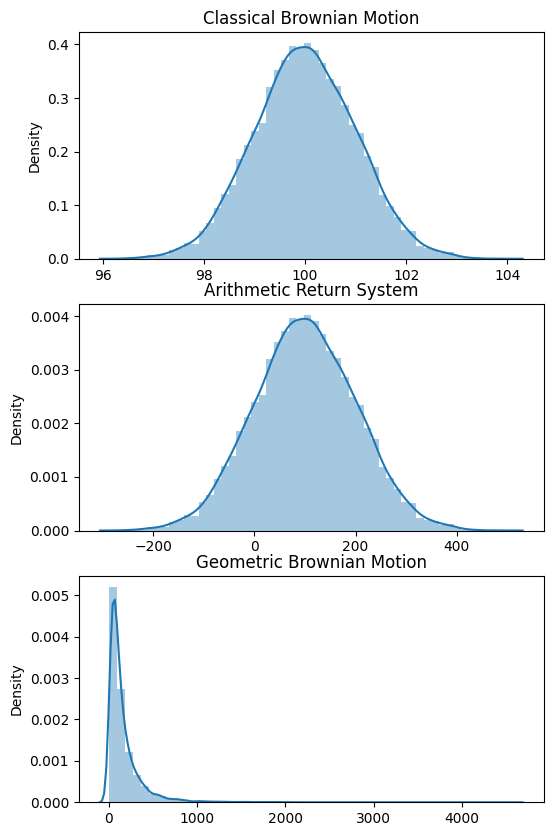

In [207]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
sns.distplot(price_brownian, ax=axes[0])
sns.distplot(price_arithmetic, ax=axes[1])
sns.distplot(price_log, ax=axes[2])
axes[0].set_title("Classical Brownian Motion")
axes[1].set_title("Arithmetic Return System")
axes[2].set_title("Geometric Brownian Motion")
plt.show()

In [ ]:
# Q2 code

In [5]:
vars = list(DP.columns)
vars.remove('Date')
p = np.array(DP[vars])
p.shape

(249, 100)

In [6]:
def return_calculate(prices: pd.DataFrame, method: str = "DISCRETE", dateColumn: str = "Date"):

    vars = list(prices.columns)
    nVars = len(vars)
    vars.remove(dateColumn)
    if nVars == len(vars):
        raise ValueError("dateColumn: " + dateColumn + " not in DataFrame: " + str(vars))
    nVars = nVars-1

    p = np.array(prices[vars])
    n = p.shape[0]
    m = p.shape[1]
    p2 = np.empty((n-1,m))
    
    for i in range(n-1):
        for j in range(m):
            p2[i,j] = p[i+1,j] / p[i,j]

    if method.upper() == "DISCRETE":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError("method: " + method + " must be in (\"LOG\",\"DISCRETE\")")

    dates = prices[dateColumn][1:n]
    out = pd.DataFrame({dateColumn: dates})
    for i in range(nVars):
        out[vars[i]] = p2[:,i]
    return out

In [7]:
# arithmetic return for all prices
all_return = return_calculate(DP, "DISCRETE", "Date")
all_return.head(5)

C:\Users\WANGLIN CAI\AppData\Local\Temp\ipykernel_2396\1745945367.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


,Date,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,2/15/2022 0:00,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
2,2/16/2022 0:00,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025984
3,2/17/2022 0:00,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030857,-0.031925,-0.033380,-0.028763
4,2/18/2022 0:00,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038
5,2/22/2022 0:00,-0.010732,-0.017812,-0.000729,-0.015753,-0.041366,-0.004521,-0.008163,-0.019790,-0.010659,...,0.009494,0.007121,-0.008891,0.003243,-0.001147,-0.000673,0.008342,-0.037654,-0.002246,-0.013605


In [8]:
# demean the return for META
Meta = all_return["META"] - all_return["META"].mean()

# check if the mean is zero
print(Meta.mean())

# set alpha
alpha = 0.05

sd = Meta.std()
sd

1.6787646541711037e-18


0.039882922468254534

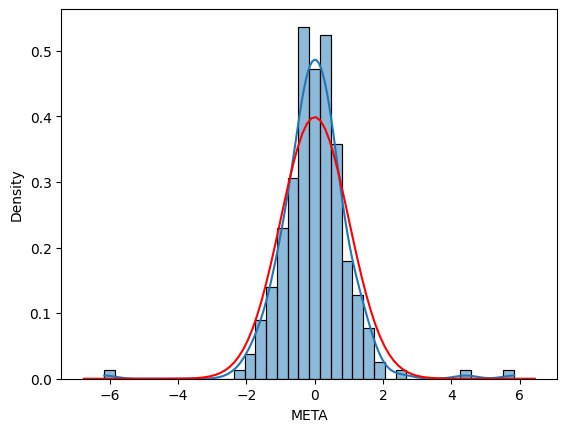

In [9]:
q = Meta/sd

hist_plot = sns.histplot(q, kde = True, stat="density")
xmin, xmax = hist_plot.get_xlim()
normal_x = np.linspace(xmin, xmax, 100)
hist_plot.plot(normal_x, norm.pdf(normal_x), color = 'red')

0.06560156967533286
0.09278155189455961


<BarContainer object of 2 artists>

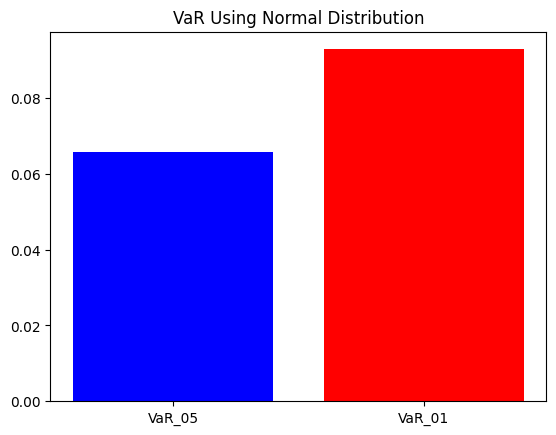

In [22]:
# 1. normal distribution

#VaR_05 = -quantile(Normal(0,sd),.05)
#VaR_01 = -quantile(Normal(0,sd),.01)

VaR_05_q1 = -norm.ppf(0.05, loc = 0, scale = sd)
VaR_01_q1 = -norm.ppf(0.01, loc = 0, scale = sd)
print(VaR_05_q1)
print(VaR_01_q1)
plt.title('VaR Using Normal Distribution')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q1, VaR_01_q1], color = ['blue','red'])

In [64]:
np.asmatrix(Meta).shape

(1, 248)

In [18]:
# 2. normal distribution with Exponentially Weighted Variance (lambda = 0.94)
def get_weight(array, L):
    
    nrows = len(array)
    weights = np.zeros(nrows)
    
    for i in range(1,nrows+1):
        weights[i-1] = (1 - L) * (L**(i-1))
        
    return weights/weights.sum()

#weights = getweight(0.97,DR.shape[0])

def weighted_variance(array, L):
    
    weights = get_weight(array, L)
    w_v = 0
    
    index = 0
    for i in array.index:
        w = weights[index]
        index += 1
        
        x = array[i]-array.mean()
        w_v += w*x**2
        
    return w_v

In [19]:
ewv = weighted_variance(Meta[::-1], 0.94)
sd2 = np.sqrt(ewv)
sd2

0.05555829372358195

0.09138526093846902
0.12924791848919145


<BarContainer object of 2 artists>

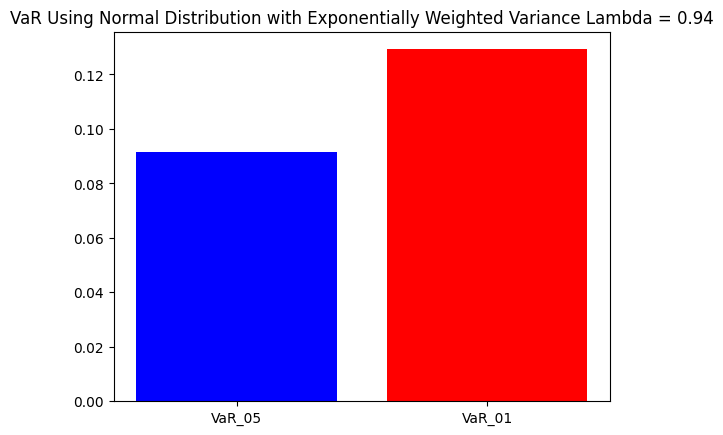

In [21]:
VaR_05_q2 = -norm.ppf(0.05, loc = 0, scale = sd2)
VaR_01_q2 = -norm.ppf(0.01, loc = 0, scale = sd2)
print(VaR_05_q2)
print(VaR_01_q2)
plt.title('VaR Using Normal Distribution with Exponentially Weighted Variance Lambda = 0.94')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q2, VaR_01_q2],color = ['blue','red'])

In [23]:
# 3. MLE fitted T distribution 

def calcLogLikelihood_t(n):
    f = 1
    for i in Meta:
        f = f * t.pdf(i,n,scale=sd)
    return -np.log(f)

res_t = minimize(calcLogLikelihood_t, 10, method = 'BFGS', options={'disp': True})

res_t.x


Optimization terminated successfully.
         Current function value: -463.957934
         Iterations: 6
         Function evaluations: 18
         Gradient evaluations: 9


array([8.84777824])

0.0732531532504567
0.1129305704912018


<BarContainer object of 2 artists>

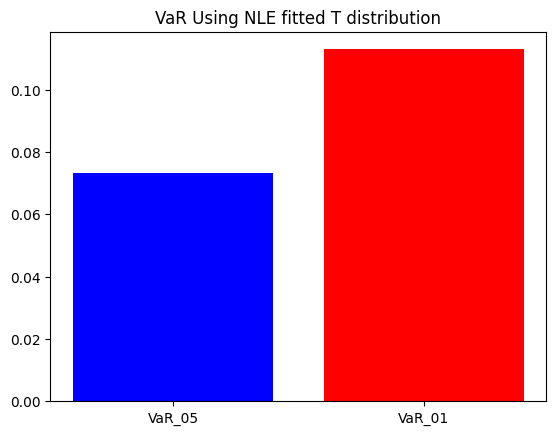

In [24]:
VaR_05_q3 = -t.ppf(0.05, df = 8.848, scale = sd)
VaR_01_q3 = -t.ppf(0.01, df = 8.848, scale = sd)
print(VaR_05_q3)
print(VaR_01_q3)
plt.title('VaR Using NLE fitted T distribution')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q3, VaR_01_q3],color = ['blue','red'])

In [197]:
# 4. fitted AR(1) Model
ar_model = AutoReg(Meta, lags = 1).fit()

ar_model.params
# so the model is xt =  -0.000062 + 0.007233xt-1 + wt

VaR_05_q4 = - (-0.000062 + 0.007233*Meta[248] + norm.ppf(0.05, loc = 0, scale = sd))
VaR_01_q4 = - (-0.000062 + 0.007233*Meta[248] + norm.ppf(0.01, loc = 0, scale = sd))
print(VaR_05_q4)
print(VaR_01_q4)
plt.title('VaR Using a fitted AR(1) model')
plt.bar(['VaR_05','VaR_01'],[VaR_05_q4, VaR_01_q4],color = ['blue','red'])

0.06588072152825065
0.09306070374747741


In [235]:
# 5. Historic Simulation
N = 10000

# here we use the same weight for the return
# therefore, the chance for each day being selected is the same
choice = np.random.randint(low = 1, high = 248, size = 10000)
simulated_return = sorted(Meta[choice])
#simulated_return[499]
H_VaR_05 = - np.quantile(simulated_return, 0.05)
H_VaR_01 = - np.quantile(simulated_return, 0.01)
print(H_VaR_05)
print(H_VaR_01)

0.06087072994079491
0.07770676546064272


In [6]:
# q3
# demean all the return
for i in range(1,101):
    all_return.iloc[:,i] = all_return.iloc[:,i] - all_return.iloc[:,i].mean()


NameError: name 'all_return' is not defined

In [111]:
def getweight(matrix, L):
    
    nrows = matrix.shape[0]
    weights = np.zeros(nrows)
    
    for i in range(1,nrows+1):
        weights[i-1] = (1 - L) * (L**(i-1))
        
    return weights/weights.sum()

#weights = getweight(0.97,DR.shape[0])

def weightedcov(matrix, L):
    
    weights = getweight(matrix, L)
    weightedcov = np.zeros([matrix.shape[1], matrix.shape[1]])
    
    for i in range(0,matrix.shape[1]):
        
        w = np.matrix(weights)
        x = np.asmatrix(matrix[:,i]-matrix[:,i].mean())
        w_x = np.zeros([1, x.shape[0]])
        
        for j in range(0,x.shape[0]):
            
            w_x[0,j] = w[0,j] * x[j,0]
            
        for k in range(0,matrix.shape[1]):
            
            y = np.asmatrix(matrix[:,k]-matrix[:,k].mean())
            
            weightedcov[i,k] += np.dot(w_x,y)
 
    return weightedcov


wcov = weightedcov(np.asmatrix(all_return[::-1].iloc[:,1:101]), L = 0.94)
wcov

#getweight(np.asmatrix(all_return[::-1].iloc[:,1:101]), L = 0.94)



array([[ 1.26482714e-04,  1.60498225e-04,  2.11666910e-04, ...,
         1.81397640e-04,  1.20191099e-04,  1.21415100e-05],
       [ 1.60498225e-04,  3.52996482e-04,  2.69735204e-04, ...,
         2.55929668e-04,  1.51299428e-04, -6.50908573e-06],
       [ 2.11666910e-04,  2.69735204e-04,  4.97465537e-04, ...,
         3.07984284e-04,  1.52281378e-04, -3.78397686e-05],
       ...,
       [ 1.81397640e-04,  2.55929668e-04,  3.07984284e-04, ...,
         7.84934935e-04,  1.71100484e-04, -1.17601047e-05],
       [ 1.20191099e-04,  1.51299428e-04,  1.52281378e-04, ...,
         1.71100484e-04,  2.50910983e-04,  7.84124017e-06],
       [ 1.21415100e-05, -6.50908573e-06, -3.78397686e-05, ...,
        -1.17601047e-05,  7.84124017e-06,  1.26941238e-04]])

In [115]:
# use MC method to generate N possible returns for the portfolio
N = 10000

# portfolio A
portfolio_a = portfolio[portfolio['Portfolio']=='A']
stock_a = portfolio_a['Stock']
return_a = all_return[stock_a]
wcov_a = weightedcov(np.asmatrix(return_a)[::-1], L = 0.94)

DP_a = DP[stock_a]
PV_a = 0
for i in range(len(stock_a)):
    PV_a += DP_a[::-1].iloc[0,:][i] * portfolio_a['Holding'].iloc[i]
    
sim_return_a = np.random.multivariate_normal(np.zeros(len(stock_a)),wcov_a,size = N)
sim_price_a = (sim_return_a + 1) * np.array(DP_a[::-1].iloc[0,:])
sim_PV_a = np.dot(sim_price_a, np.array(portfolio_a['Holding']))
sim_PV_a = sorted(sim_PV_a)

index_05_a = int(0.05*N-1)
index_01_a = int(0.01*N-1)

VaR_05_a = PV_a - sim_PV_a[index_05_a]
VaR_01_a = PV_a - sim_PV_a[index_01_a]

print(VaR_05_a)
print(VaR_01_a)

5681.897369566315
8044.168520905427


In [85]:
sim_price_a

array([[149.79398332, 203.35854729, 140.69750554, ..., 179.26772893,
        264.73883992,  80.32602155],
       [151.52842243, 203.66146463, 144.57517136, ..., 176.50834017,
        260.55800086,  83.47951297],
       [149.09830406, 203.56068001, 141.7633855 , ..., 175.6754401 ,
        264.81958267,  82.51937759],
       ...,
       [150.08112253, 211.43406337, 138.31630996, ..., 177.95449241,
        263.38682603,  80.03595556],
       [154.13305004, 222.82180778, 138.95149017, ..., 180.55248099,
        264.86739576,  80.04806412],
       [152.30794027, 221.49292642, 138.73542547, ..., 178.56918072,
        258.9475676 ,  78.51792406]])

In [116]:
# portfolio B
portfolio_b = portfolio[portfolio['Portfolio']=='B']
stock_b = portfolio_b['Stock']
return_b = all_return[stock_b]
wcov_b = weightedcov(np.asmatrix(return_b)[::-1], L = 0.94)
DP_b = DP[stock_b]
PV_b = 0
for i in range(len(stock_b)):
    PV_b += DP_b[::-1].iloc[0,:][i] * portfolio_b['Holding'].iloc[i]

sim_return_b = np.random.multivariate_normal(np.zeros(len(stock_b)),wcov_b,size = N)
sim_price_b = (sim_return_b + 1) * np.array(DP_b[::-1].iloc[0,:])
sim_PV_b = np.dot(sim_price_b, np.array(portfolio_b['Holding']))
sim_PV_b = sorted(sim_PV_b)

index_05_b = int(0.05*N-1)
index_01_b = int(0.01*N-1)

VaR_05_b = PV_b - sim_PV_b[index_05_b]
VaR_01_b = PV_b - sim_PV_b[index_01_b]

print(VaR_05_b)
print(VaR_01_b)

4517.706471523095
6279.945363393344


In [119]:
# portfolio C
portfolio_c = portfolio[portfolio['Portfolio']=='C']
stock_c = portfolio_c['Stock']
return_c = all_return[stock_c]
wcov_c = weightedcov(np.asmatrix(return_c)[::-1], L = 0.94)
DP_c = DP[stock_c]
PV_c = 0
for i in range(len(stock_c)):
    PV_c += DP_c[::-1].iloc[0,:][i] * portfolio_c['Holding'].iloc[i]

sim_return_c = np.random.multivariate_normal(np.zeros(len(stock_c)),wcov_c,size = N)
sim_price_c = (sim_return_c + 1) * np.array(DP_c[::-1].iloc[0,:])
sim_PV_c = np.dot(sim_price_c, np.array(portfolio_c['Holding']))
sim_PV_c = sorted(sim_PV_c)

index_05_c = int(0.05*N-1)
index_01_c = int(0.01*N-1)

VaR_05_c = PV_c - sim_PV_c[index_05_c]
VaR_01_c = PV_c - sim_PV_c[index_01_c]

print(VaR_05_c)
print(VaR_01_c)

3777.8275708475267
5373.011768021679


In [120]:
# Total portfolio
portfolio_t = portfolio
stock_t = portfolio_t['Stock']
return_t = all_return[stock_t]
wcov_t = weightedcov(np.asmatrix(return_t)[::-1], L = 0.94)
DP_t = DP[stock_t]
PV_t = 0
for i in range(len(stock_t)):
    PV_t += DP_t[::-1].iloc[0,:][i] * portfolio_t['Holding'].iloc[i]

sim_return_t = np.random.multivariate_normal(np.zeros(len(stock_t)),wcov_t,size = N)
sim_price_t = (sim_return_t + 1) * np.array(DP_t[::-1].iloc[0,:])
sim_PV_t = np.dot(sim_price_t, np.array(portfolio_t['Holding']))
sim_PV_t = sorted(sim_PV_t)

index_05_t = int(0.05*N-1)
index_01_t = int(0.01*N-1)

VaR_05_t = PV_t - sim_PV_t[index_05_t]
VaR_01_t = PV_t - sim_PV_t[index_01_t]

print(VaR_05_t)
print(VaR_01_t)

13522.296780998586
19174.06954077049


In [132]:
# historic simulation
# portfolio a

hs_a = np.random.randint(low = 1, high = 248, size = N)
hs_return_a = np.zeros([N,len(stock_a)])
for i in range(N):
    for j in range(len(stock_a)):
        hs_return_a[i,j] = return_a.iloc[hs_a[i],j]

hs_price_a = (hs_return_a + 1) * np.array(DP_a[::-1].iloc[0,:])

hs_PV_a = np.dot(hs_price_a, np.array(portfolio_a['Holding']))
hs_PV_a = sorted(hs_PV_a) 

hs_index_05_a = int(0.05*N-1)
hs_index_01_a = int(0.01*N-1)

hs_VaR_05_a = PV_a - hs_PV_a[hs_index_05_a]
hs_VaR_01_a = PV_a - hs_PV_a[hs_index_01_a]

print(hs_VaR_05_a)
print(hs_VaR_01_a)

9138.87426422484
10940.363392684027


In [133]:
# portfolio b

hs_b = np.random.randint(low = 1, high = 248, size = N)
hs_return_b = np.zeros([N,len(stock_b)])
for i in range(N):
    for j in range(len(stock_b)):
        hs_return_b[i,j] = return_b.iloc[hs_b[i],j]

hs_price_b = (hs_return_b + 1) * np.array(DP_b[::-1].iloc[0,:])

hs_PV_b = np.dot(hs_price_b, np.array(portfolio_b['Holding']))
hs_PV_b = sorted(hs_PV_b) 

hs_index_05_b = int(0.05*N-1)
hs_index_01_b = int(0.01*N-1)

hs_VaR_05_b = PV_b - hs_PV_b[hs_index_05_b]
hs_VaR_01_b = PV_b - hs_PV_b[hs_index_01_b]

print(hs_VaR_05_b)
print(hs_VaR_01_b)

7001.117454413907
10225.133956822567


In [134]:
# portfolio c

hs_c = np.random.randint(low = 1, high = 248, size = N)
hs_return_c = np.zeros([N,len(stock_c)])
for i in range(N):
    for j in range(len(stock_c)):
        hs_return_c[i,j] = return_c.iloc[hs_c[i],j]

hs_price_c = (hs_return_c + 1) * np.array(DP_c[::-1].iloc[0,:])

hs_PV_c = np.dot(hs_price_c, np.array(portfolio_c['Holding']))
hs_PV_c = sorted(hs_PV_c) 

hs_index_05_c = int(0.05*N-1)
hs_index_01_c = int(0.01*N-1)

hs_VaR_05_c = PV_c - hs_PV_c[hs_index_05_c]
hs_VaR_01_c = PV_c - hs_PV_c[hs_index_01_c]

print(hs_VaR_05_c)
print(hs_VaR_01_c)

5558.724403455795
8326.665866377356


In [136]:
hs = np.random.randint(low = 1, high = 248, size = N)
hs_return = np.zeros([N,len(stock_t)])
for i in range(N):
    for j in range(len(stock_t)):
        hs_return[i,j] = return_t.iloc[hs[i],j]

hs_price = (hs_return + 1) * np.array(DP_t[::-1].iloc[0,:])

hs_PV = np.dot(hs_price, np.array(portfolio_t['Holding']))
hs_PV = sorted(hs_PV) 

hs_index_05 = int(0.05*N-1)
hs_index_01 = int(0.01*N-1)

hs_VaR_05 = PV_t - hs_PV[hs_index_05]
hs_VaR_01 = PV_t - hs_PV[hs_index_01]

print(hs_VaR_05)
print(hs_VaR_01)

21103.398010768462
30652.971591943875


In [86]:
# Using original covariance for returns
# portfolio A

portfolio_a = portfolio[portfolio['Portfolio']=='A']
stock_a = portfolio_a['Stock']
return_a = all_return[stock_a]
cov_a = all_return[stock_a].cov()
DP_a = DP[stock_a]
PV_a = 0
for i in range(len(stock_a)):
    PV_a += DP_a[::-1].iloc[0,:][i] * portfolio_a['Holding'].iloc[i]
    
sim_return_a = np.random.multivariate_normal(np.zeros(len(stock_a)),cov_a,size = N)
sim_price_a = (sim_return_a + 1) * np.array(DP_a[::-1].iloc[0,:])
sim_PV_a = np.dot(sim_price_a, np.array(portfolio_a['Holding']))
sim_PV_a = sorted(sim_PV_a)

index_05_a = int(0.05*N-1)
index_01_a = int(0.01*N-1)

VaR_05_a = PV_a - sim_PV_a[index_05_a]
VaR_01_a = PV_a - sim_PV_a[index_01_a]

print(VaR_05_a)
print(VaR_01_a)


8116.532733458735
11328.262231245346


In [87]:
sim_price_a

array([[150.33372411, 191.56209159, 141.92919946, ..., 179.22075228,
        261.74639345,  80.66082231],
       [151.07465996, 199.81804206, 138.97566091, ..., 177.78861714,
        260.6620219 ,  80.35430777],
       [153.3157226 , 215.68227288, 139.2403373 , ..., 180.79694561,
        264.55978864,  80.41919855],
       ...,
       [154.79796957, 224.32605009, 143.33296726, ..., 182.67067189,
        273.15621474,  84.39057684],
       [156.25574275, 222.88241013, 139.08633955, ..., 182.16039776,
        269.20994479,  82.99716218],
       [147.57668219, 201.02792221, 136.15102807, ..., 174.3771412 ,
        260.20016256,  77.60521028]])

In [29]:
# portfolio B
portfolio_b = portfolio[portfolio['Portfolio']=='B']
stock_b = portfolio_b['Stock']
return_b = all_return[stock_b]
cov_b = all_return[stock_b].cov()
DP_b = DP[stock_b]
PV_b = 0
for i in range(len(stock_b)):
    PV_b += DP_b[::-1].iloc[0,:][i] * portfolio_b['Holding'].iloc[i]

sim_return_b = np.random.multivariate_normal(np.zeros(len(stock_b)),cov_b,size = N)
sim_price_b = (sim_return_b + 1) * np.array(DP_b[::-1].iloc[0,:])
sim_PV_b = np.dot(sim_price_b, np.array(portfolio_b['Holding']))
sim_PV_b = sorted(sim_PV_b)

index_05_b = int(0.05*N-1)
index_01_b = int(0.01*N-1)

VaR_05_b = PV_b - sim_PV_b[index_05_b]
VaR_01_b = PV_b - sim_PV_b[index_01_b]

print(VaR_05_b)
print(VaR_01_b)

6612.32826432545
9412.13130945951


In [30]:
# portfolio C
portfolio_c = portfolio[portfolio['Portfolio']=='C']
stock_c = portfolio_c['Stock']
return_c = all_return[stock_c]
cov_c = all_return[stock_c].cov()
DP_c = DP[stock_c]
PV_c = 0
for i in range(len(stock_c)):
    PV_c += DP_c[::-1].iloc[0,:][i] * portfolio_c['Holding'].iloc[i]

sim_return_c = np.random.multivariate_normal(np.zeros(len(stock_c)),cov_c,size = N)
sim_price_c = (sim_return_c + 1) * np.array(DP_c[::-1].iloc[0,:])
sim_PV_c = np.dot(sim_price_c, np.array(portfolio_c['Holding']))
sim_PV_c = sorted(sim_PV_c)

index_05_c = int(0.05*N-1)
index_01_c = int(0.01*N-1)

VaR_05_c = PV_c - sim_PV_c[index_05_c]
VaR_01_c = PV_c - sim_PV_c[index_01_c]

print(VaR_05_c)
print(VaR_01_c)

5686.203007541073
8050.38267087948


In [31]:
# Total portfolio
portfolio_t = portfolio
stock_t = portfolio_t['Stock']
return_t = all_return[stock_t]
cov_t = all_return[stock_t].cov()
DP_t = DP[stock_t]
PV_t = 0
for i in range(len(stock_t)):
    PV_t += DP_t[::-1].iloc[0,:][i] * portfolio_t['Holding'].iloc[i]

sim_return_t = np.random.multivariate_normal(np.zeros(len(stock_t)),cov_t,size = N)
sim_price_t = (sim_return_t + 1) * np.array(DP_t[::-1].iloc[0,:])
sim_PV_t = np.dot(sim_price_t, np.array(portfolio_t['Holding']))
sim_PV_t = sorted(sim_PV_t)

index_05_t = int(0.05*N-1)
index_01_t = int(0.01*N-1)

VaR_05_t = PV_t - sim_PV_t[index_05_t]
VaR_01_t = PV_t - sim_PV_t[index_01_t]

print(VaR_05_t)
print(VaR_01_t)

20307.450596767943
28485.81575254735


In [51]:
cov_a

,AAPL,TSLA,JPM,HD,BAC,XOM,AVGO,PEP,TMO,CMCSA,...,SBUX,GE,ISRG,MU,NOW,ADP,PNC,ADI,SYK,TJX
AAPL,0.000503,0.000615,0.000233,0.000263,0.000263,0.000150,0.000387,0.000145,0.000278,0.000216,...,0.000299,0.000274,0.000383,0.000471,0.000484,0.000277,0.000255,0.000384,0.000270,0.000213
TSLA,0.000615,0.001818,0.000270,0.000309,0.000335,0.000169,0.000539,0.000122,0.000372,0.000256,...,0.000465,0.000388,0.000518,0.000678,0.000802,0.000322,0.000347,0.000516,0.000316,0.000339
JPM,0.000233,0.000270,0.000329,0.000173,0.000329,0.000116,0.000236,0.000108,0.000186,0.000176,...,0.000235,0.000259,0.000245,0.000310,0.000257,0.000172,0.000283,0.000250,0.000206,0.000218
HD,0.000263,0.000309,0.000173,0.000385,0.000184,0.000063,0.000257,0.000125,0.000226,0.000183,...,0.000232,0.000188,0.000295,0.000293,0.000390,0.000212,0.000210,0.000255,0.000227,0.000228
BAC,0.000263,0.000335,0.000329,0.000184,0.000401,0.000130,0.000262,0.000107,0.000209,0.000194,...,0.000249,0.000284,0.000267,0.000339,0.000300,0.000183,0.000317,0.000273,0.000224,0.000236
XOM,0.000150,0.000169,0.000116,0.000063,0.000130,0.000476,0.000158,0.000050,0.000113,0.000075,...,0.000089,0.000160,0.000153,0.000129,0.000145,0.000123,0.000121,0.000135,0.000097,0.000066
AVGO,0.000387,0.000539,0.000236,0.000257,0.000262,0.000158,0.000518,0.000128,0.000270,0.000232,...,0.000327,0.000299,0.000384,0.000517,0.000488,0.000261,0.000266,0.000430,0.000285,0.000209
PEP,0.000145,0.000122,0.000108,0.000125,0.000107,0.000050,0.000128,0.000154,0.000101,0.000091,...,0.000123,0.000092,0.000146,0.000114,0.000127,0.000125,0.000108,0.000118,0.000130,0.000082
TMO,0.000278,0.000372,0.000186,0.000226,0.000209,0.000113,0.000270,0.000101,0.000416,0.000142,...,0.000253,0.000217,0.000354,0.000333,0.000424,0.000213,0.000208,0.000289,0.000272,0.000160
CMCSA,0.000216,0.000256,0.000176,0.000183,0.000194,0.000075,0.000232,0.000091,0.000142,0.000371,...,0.000199,0.000212,0.000260,0.000282,0.000300,0.000173,0.000207,0.000238,0.000205,0.000150


In [52]:
pd.DataFrame(wcov_a)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.609334e-04,0.000167,0.000016,-2.806110e-05,1.762660e-06,0.000018,2.397246e-07,-2.830178e-05,-2.042580e-05,-0.000042,...,-9.006517e-05,-3.425807e-05,-0.000006,4.183158e-05,-0.000018,-1.377462e-05,-2.628204e-05,0.000024,-0.000022,-2.553849e-05
1,1.669279e-04,0.002010,-0.000117,-1.317931e-04,-1.047655e-04,-0.000051,-1.957050e-05,-1.223240e-04,-8.532024e-05,-0.000243,...,-9.600455e-05,5.927293e-05,-0.000143,1.203468e-04,0.000152,-2.830196e-04,-4.424506e-05,0.000047,-0.000085,-1.281124e-04
2,1.626790e-05,-0.000117,0.000160,-9.838323e-06,1.072093e-04,0.000120,1.089166e-05,1.092607e-04,1.363504e-05,-0.000016,...,3.713917e-05,2.512289e-05,-0.000052,-5.282977e-05,-0.000147,2.560946e-05,5.812645e-05,-0.000005,-0.000063,1.249161e-04
3,-2.806110e-05,-0.000132,-0.000010,1.474283e-04,-4.339231e-06,-0.000080,-3.935038e-05,2.728124e-05,-1.976183e-05,0.000011,...,-7.772210e-06,3.956511e-05,0.000006,-1.173493e-04,-0.000016,1.933672e-05,2.241446e-05,-0.000028,-0.000024,6.975394e-07
4,1.762660e-06,-0.000105,0.000107,-4.339231e-06,1.096933e-04,0.000068,1.239045e-06,5.358222e-05,1.074839e-05,0.000008,...,1.714609e-05,2.245477e-05,-0.000034,-2.648930e-05,-0.000102,-4.153557e-07,5.847318e-05,-0.000016,-0.000023,7.437617e-05
5,1.753137e-05,-0.000051,0.000120,-7.965331e-05,6.786811e-05,0.000345,5.725102e-05,1.206856e-04,2.838506e-05,-0.000033,...,7.982535e-05,-4.606056e-05,-0.000017,-3.135757e-05,-0.000060,4.717524e-05,2.971270e-05,-0.000004,-0.000115,1.714451e-04
6,2.397246e-07,-0.000020,0.000011,-3.935038e-05,1.239045e-06,0.000057,1.148812e-04,3.401192e-05,-5.339835e-05,0.000003,...,3.631153e-05,-2.923896e-05,-0.000003,3.574355e-05,-0.000040,1.888455e-06,-2.366045e-05,0.000037,-0.000012,2.716144e-05
7,-2.830178e-05,-0.000122,0.000109,2.728124e-05,5.358222e-05,0.000121,3.401192e-05,2.191764e-04,-1.642948e-05,-0.000029,...,9.058937e-05,7.593816e-07,-0.000059,-1.186088e-04,-0.000128,5.741928e-05,3.601465e-05,-0.000001,-0.000068,1.960438e-04
8,-2.042580e-05,-0.000085,0.000014,-1.976183e-05,1.074839e-05,0.000028,-5.339835e-05,-1.642948e-05,1.946395e-04,-0.000002,...,-1.967602e-05,8.923231e-07,-0.000004,2.002395e-05,0.000020,9.624997e-06,-1.080217e-05,-0.000012,0.000081,3.531811e-06
9,-4.170452e-05,-0.000243,-0.000016,1.050265e-05,7.723058e-06,-0.000033,2.925714e-06,-2.884618e-05,-2.149052e-06,0.000118,...,1.083654e-05,1.170549e-05,0.000018,1.721229e-05,-0.000007,-5.618387e-06,3.183721e-05,-0.000031,-0.000023,-3.359831e-05


In [73]:
return_a

,AAPL,TSLA,JPM,HD,BAC,XOM,AVGO,PEP,TMO,CMCSA,...,SBUX,GE,ISRG,MU,NOW,ADP,PNC,ADI,SYK,TJX
1,0.023152,0.053291,0.014624,0.004836,0.007803,-0.012535,0.041809,-0.004439,-0.008054,0.013713,...,0.009183,0.044720,0.029060,0.068328,0.020843,0.010100,0.012807,0.052344,0.033021,0.013237
2,-0.001389,0.001041,0.001810,-0.008974,-0.002302,0.004616,-0.009224,0.002049,-0.011353,0.000833,...,0.007089,0.004855,0.006325,0.000625,-0.001301,0.001078,0.006757,0.038879,0.003363,-0.025984
3,-0.021269,-0.050943,-0.023032,-0.006141,-0.033767,-0.001531,-0.030492,0.002706,-0.017825,-0.027449,...,-0.022379,-0.029090,-0.024250,-0.024256,-0.042546,-0.018508,-0.034949,-0.046988,-0.030857,-0.028763
4,-0.009356,-0.022103,0.004689,-0.003075,-0.002388,-0.011121,0.001710,0.005757,-0.006290,-0.002780,...,0.003117,-0.058602,-0.011616,-0.031260,-0.017216,-0.000050,-0.000646,-0.000436,-0.013674,0.015038
5,-0.017812,-0.041366,-0.001775,-0.088506,-0.008703,-0.011634,-0.004362,0.003816,-0.013498,0.006432,...,-0.002464,0.015751,0.011468,-0.002533,-0.010539,-0.002744,0.009494,0.003243,0.008342,-0.013605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.024400,0.009083,0.015474,-0.024397,0.008303,0.006928,-0.013454,-0.005001,0.001175,-0.027730,...,-0.044434,-0.023588,-0.023841,-0.012031,-0.038777,-0.016071,-0.004694,-0.002677,0.002336,0.001617
245,-0.017929,0.025161,0.005883,-0.006727,-0.001647,-0.001698,0.006158,0.015965,-0.019719,-0.011509,...,0.006903,0.004758,-0.022381,-0.038936,-0.036000,-0.008167,-0.014451,-0.007102,-0.041181,-0.004595
246,0.019245,0.010526,0.012190,-0.012361,0.010998,0.028551,0.021869,-0.001513,0.012115,0.004050,...,0.017235,-0.002914,0.016387,0.035845,0.017662,0.014767,-0.000368,0.019544,0.003573,-0.003618
247,-0.017653,0.022763,-0.007031,-0.013561,-0.007343,-0.008702,-0.020734,-0.002332,-0.006722,-0.022939,...,-0.004961,-0.001827,-0.016636,-0.030259,0.001554,-0.012303,-0.008469,-0.018009,-0.015526,0.009363


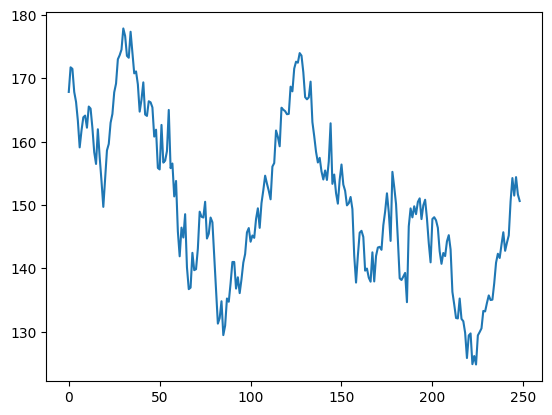